# Imports

In [28]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

import pyod

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.patches as mpatches

# Dataset Exploration

In [29]:
# Read the CSV file into a dataframe
import pandas as pd

DATA = pd.read_csv("DSL-StrongPasswordData.csv")
SUBJECTS = DATA["subject"].unique()
# Display information about the dataset
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20400 entries, 0 to 20399
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subject          20400 non-null  object 
 1   sessionIndex     20400 non-null  int64  
 2   rep              20400 non-null  int64  
 3   H.period         20400 non-null  float64
 4   DD.period.t      20400 non-null  float64
 5   UD.period.t      20400 non-null  float64
 6   H.t              20400 non-null  float64
 7   DD.t.i           20400 non-null  float64
 8   UD.t.i           20400 non-null  float64
 9   H.i              20400 non-null  float64
 10  DD.i.e           20400 non-null  float64
 11  UD.i.e           20400 non-null  float64
 12  H.e              20400 non-null  float64
 13  DD.e.five        20400 non-null  float64
 14  UD.e.five        20400 non-null  float64
 15  H.five           20400 non-null  float64
 16  DD.five.Shift.r  20400 non-null  float64
 17  UD.five.Shif

In [30]:
# Display descriptive statistics of the dataframe
DATA.describe()

,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,H.e,DD.e.five,UD.e.five,H.five,DD.five.Shift.r,UD.five.Shift.r,H.Shift.r,DD.Shift.r.o,UD.Shift.r.o,H.o,DD.o.a,UD.o.a,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
count,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000
mean,4.500000,25.500000,0.093379,0.264148,0.170769,0.085727,0.169085,0.083358,0.081565,0.159372,0.077806,0.089138,0.377434,0.288295,0.076904,0.438887,0.361983,0.095937,0.250921,0.154984,0.088354,0.156931,0.068577,0.106259,0.150670,0.044411,0.089899,0.202630,0.112731,0.095589,0.321847,0.226259,0.088306
std,2.291344,14.431223,0.029626,0.220534,0.226836,0.027424,0.123546,0.125755,0.026887,0.226928,0.228512,0.030635,0.265342,0.266695,0.021746,0.260343,0.260886,0.033900,0.174533,0.181619,0.026427,0.106557,0.108509,0.038828,0.107422,0.105197,0.030738,0.150191,0.159571,0.028348,0.225389,0.230759,0.027452
min,1.000000,1.000000,0.001400,0.018700,-0.235800,0.009300,0.001100,-0.162100,0.003200,0.001400,-0.160000,0.002100,0.001300,-0.150500,0.001400,0.169400,0.085600,0.001400,0.049400,-0.086500,0.006900,0.001200,-0.228700,0.004000,0.001100,-0.235500,0.003700,0.001300,-0.175800,0.003700,0.008300,-0.124500,0.002900
25%,2.750000,13.000000,0.074400,0.146900,0.049800,0.066000,0.113600,0.027200,0.062000,0.089300,0.007400,0.068600,0.216600,0.133200,0.061000,0.307900,0.229675,0.070200,0.156500,0.054700,0.071500,0.106400,0.017000,0.082100,0.096100,-0.009000,0.067300,0.127600,0.023500,0.077400,0.210000,0.114100,0.069900
50%,4.500000,25.500000,0.089500,0.205950,0.108700,0.081000,0.140400,0.057800,0.077100,0.120900,0.041200,0.083400,0.289000,0.200400,0.074200,0.377500,0.302000,0.093500,0.201350,0.102200,0.086300,0.131600,0.044400,0.101900,0.125000,0.022700,0.085300,0.172500,0.095500,0.093700,0.263000,0.160300,0.085500
75%,6.250000,38.000000,0.107900,0.306450,0.212400,0.099800,0.183900,0.096400,0.096900,0.173100,0.093400,0.102700,0.456850,0.369400,0.090600,0.486025,0.408900,0.116700,0.283425,0.191000,0.101900,0.167600,0.080300,0.122300,0.174600,0.068900,0.107900,0.228800,0.145700,0.111100,0.350200,0.255100,0.103700
max,8.000000,50.000000,0.376100,12.506100,12.451700,0.241100,4.919700,4.799900,0.331200,25.987300,25.915800,0.325400,4.961800,4.882700,0.198900,8.370200,8.290800,0.281700,4.152300,4.012000,0.687200,2.856700,2.815200,2.035300,3.327800,2.524200,0.357700,4.025200,3.978200,0.340700,5.883600,5.836400,0.265100


<Axes: ylabel='subject'>

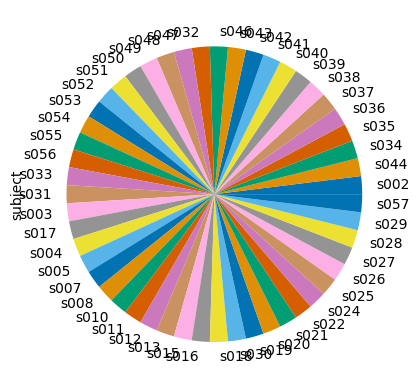

In [31]:
# Plotting the pie chart for the 'subject' column
# Count the number of occurrences of each unique value in the 'subject' column
# Plot a pie chart to visualize the distribution of subjects
DATA["subject"].value_counts().plot(kind="pie")

In [32]:
# Get the unique user IDs from the 'subject' column
USER_IDS = DATA["subject"].unique()

# Randomly select 6 user IDs from the unique user IDs
SAMPLE_USERS = ["s005", "s016", "s018", "s026", "s043", "s057"]
# Filter the dataframe to include only the rows with the selected user IDs
SAMPLE_CMU_KEYSTROKE_DF = DATA[DATA["subject"].isin(SAMPLE_USERS)]

# Display the top rows of the filtered dataframe
SAMPLE_CMU_KEYSTROKE_DF.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,H.e,DD.e.five,UD.e.five,H.five,DD.five.Shift.r,UD.five.Shift.r,H.Shift.r,DD.Shift.r.o,UD.Shift.r.o,H.o,DD.o.a,UD.o.a,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
1200,s005,1,1,0.0729,0.2393,0.1664,0.1254,0.3416,0.2162,0.0853,0.8068,0.7215,0.1206,0.7183,0.5977,0.0660,0.8672,0.8012,0.1124,0.6804,0.5680,0.1000,1.3723,1.2723,0.1840,0.5625,0.3785,0.0747,0.3779,0.3032,0.0866,0.6034,0.5168,0.0797
1201,s005,1,2,0.0721,0.9983,0.9262,0.1077,0.3803,0.2726,0.0752,0.2610,0.1858,0.1512,0.4964,0.3452,0.1114,1.1198,1.0084,0.1473,0.8163,0.6690,0.0971,0.3054,0.2083,0.1570,0.2756,0.1186,0.0982,0.5534,0.4552,0.0560,0.4995,0.4435,0.1074
1202,s005,1,3,0.0631,1.2671,1.2040,0.1362,0.3254,0.1892,0.0792,0.2581,0.1789,0.1293,0.5125,0.3832,0.1045,0.7628,0.6583,0.1325,0.4542,0.3217,0.0884,0.5951,0.5067,0.1787,0.2854,0.1067,0.0483,1.0708,1.0225,0.0634,0.5000,0.4366,0.0871
1203,s005,1,4,0.1040,0.6528,0.5488,0.1288,0.4310,0.3022,0.0977,0.2988,0.2011,0.1143,0.4703,0.3560,0.1066,0.7178,0.6112,0.1135,0.3721,0.2586,0.1082,0.2701,0.1619,0.1399,0.3305,0.1906,0.0803,0.4286,0.3483,0.0916,0.7449,0.6533,0.1388
1204,s005,1,5,0.0837,0.6212,0.5375,0.1090,0.4267,0.3177,0.0924,0.2774,0.1850,0.0905,0.4518,0.3613,0.1027,0.7282,0.6255,0.1111,0.4226,0.3115,0.0882,0.1751,0.0869,0.1280,0.2405,0.1125,0.0869,0.4389,0.3520,0.1241,0.5227,0.3986,0.0958


In [34]:
# Drop the 'sessionIndex' and 'rep' columns from the 'sample_cmu_keystroke_df' dataframe

SAMPLE_CMU_KEYSTROKE_DF = SAMPLE_CMU_KEYSTROKE_DF.drop(["sessionIndex", "rep"], axis=1)

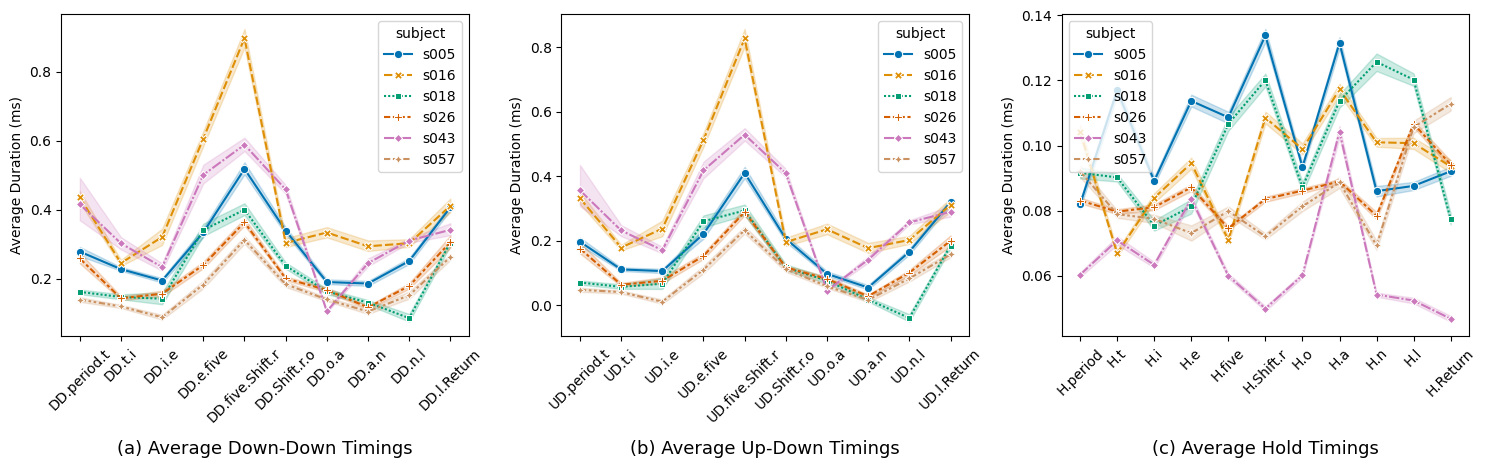

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create three subsets of the sample dataset
# Each subset consists of either DD, UD, or H features

# Subset for DD features
DF_DD = SAMPLE_CMU_KEYSTROKE_DF[
    [col for col in SAMPLE_CMU_KEYSTROKE_DF.columns if "DD" in col or col == "subject"]
]


# Subset for UD features
DF_UD = SAMPLE_CMU_KEYSTROKE_DF[
    [col for col in SAMPLE_CMU_KEYSTROKE_DF.columns if "UD" in col or col == "subject"]
]


# Subset for H features
DF_H = SAMPLE_CMU_KEYSTROKE_DF[
    [col for col in SAMPLE_CMU_KEYSTROKE_DF.columns if "H" in col or col == "subject"]
]

def draw_graph(dataframes, figname):
    # Set the color palette to "colorblind"
    sns.set_palette("colorblind")
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Define letters and descriptions
    letters = ['a', 'b', 'c']
    descriptions = ['Average Down-Down Timings', 'Average Up-Down Timings', 'Average Hold Timings']

    # Loop through each dataframe and draw the graph on the corresponding subplot
    for i, (df, title) in enumerate(dataframes):
        # Plot the line graph with different line styles for each subject
        sns.lineplot(x="keystroke", y="value", hue="subject", style="subject", markers=True, data=df, ax=axes[i])
        
        # Rotate the x-axis labels
        axes[i].tick_params(axis='x', rotation=45)
        
        # Set the x-axis label
        axes[i].set_xlabel(None)     

        # Set the y-axis label
        axes[i].set_ylabel("Average Duration (ms)")
        
        # Set the title
        axes[i].set_title(None)

        # Add letter and description at the bottom
        axes[i].text(0.5, -0.35, f"({letters[i]}) {descriptions[i]}", ha='center', va='center', transform=axes[i].transAxes, fontsize=13)

    # Adjust the layout
    plt.tight_layout()

    # Save the figure
    plt.savefig(figname, dpi=300)

    # Show the graph
    plt.show()


# Reshape the 'DF_DD', 'DF_UD', and 'DF_H' dataframes using the 'melt' function
import pandas as pd

DF_DD = pd.melt(DF_DD, id_vars="subject", var_name="keystroke")
DF_UD = pd.melt(DF_UD, id_vars="subject", var_name="keystroke")
DF_H = pd.melt(DF_H, id_vars="subject", var_name="keystroke")

# Draw the graphs for DD, UD, and H features side by side in a single figure
draw_graph([(DF_DD, "DD"), (DF_UD, "UD"), (DF_H, "H")], "Figure 2.png") 


# Model Implementation

## Functions

In [10]:
import numpy as np


def evaluate(alluser_scores, allimposter_scores):
    """
    Function to evaluate Equal Error Rate (EER), Area Under the Curve (AUC), Accuracy (ACC),
    Precision, Recall, and F1-Score.

    Parameters:
    alluser_scores (array-like): Array of scores for genuine users
    allimposter_scores (array-like): Array of scores for imposters

    Returns:
    EER (float): Equal Error Rate
    AUC (float): Area Under the Curve
    ACC (float): Accuracy
    Precision (float): Precision
    Recall (float): Recall
    F1-Score (float): F1-Score
    """
    labels = [0] * len(alluser_scores) + [1] * len(allimposter_scores)
    temp_scores = np.append(alluser_scores, allimposter_scores)

    fpr, tpr, thresholds = roc_curve(labels, temp_scores, drop_intermediate=False, pos_label=1)
    fnr = 1 - tpr
    thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    eer = brentq(lambda x: 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)

    auc = roc_auc_score(labels, temp_scores)

    temp_scores[temp_scores >= 0.5] = 1
    temp_scores[temp_scores < 0.5] = 0

    acc = accuracy_score(labels, temp_scores)
    precision = precision_score(labels, temp_scores)
    recall = recall_score(labels, temp_scores)
    f1 = f1_score(labels, temp_scores)

    return eer, auc, acc, precision, recall, f1

In [11]:
import pandas as pd
import numpy as np

def evaluate_classifier(clf):
    """
    Function to evaluate the classifier

    Parameters:
    clf (object): Classifier object

    Returns:
    allUserScores (array-like): Array of scores for genuine users
    allImposterScores (array-like): Array of scores for imposters
    res (dict): Dictionary of evaluation results
    """
    data = pd.read_csv("DSL-StrongPasswordData.csv")
    subjects = data["subject"].unique()
    
    res = {}
    aucs = []
    eers = []
    accs = []
    all_user_scores = np.array([])
    all_imposter_scores = np.array([])
    for subject in subjects:
        genuine_user_data = data.loc[data["subject"] == subject, "H.period":]
        imposter_data = data.loc[data["subject"] != subject, :]

        train = genuine_user_data[:200].values

        test_genuine = genuine_user_data[200:].values

        test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":].values

        clf.fit(train)

        user_scores = clf.predict_proba(test_genuine)
        imposter_scores = clf.predict_proba(test_imposter)
    
        (eer, auc, acc, precision, recall, f1) = evaluate(user_scores[:, 1], imposter_scores[:, 1])
    
        eers.append(eer)
        aucs.append(auc)
        accs.append(acc)

        all_user_scores = np.append(all_user_scores, user_scores[:, 1])
        all_imposter_scores = np.append(all_imposter_scores, imposter_scores[:, 1])
    
    res["EER"] = round(np.mean(eers) * 100, 2)
    res["ACC"] = round(np.mean(accs) * 100, 2)
    res["AUC"] = round(np.mean(aucs) * 100, 2)
    res["Precision"] = round(np.mean(precision) * 100, 2)
    res["Recall"] = round(np.mean(recall) * 100, 2)
    res["F1-Score"] = round(np.mean(f1) * 100, 2)
    
    return all_user_scores, all_imposter_scores, res


## Model Definition and Training

In [12]:
# detector list for LSCP
import numpy as np

from pyod.models.pca import PCA
from pyod.models.ocsvm import OCSVM
from pyod.models.lscp import LSCP
from pyod.models.lof import LOF
from pyod.models.lmdd import LMDD
from pyod.models.knn import KNN
from pyod.models.kde import KDE
from pyod.models.inne import INNE
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.models.gmm import GMM
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.cblof import CBLOF
from pyod.models.abod import ABOD
DETECTOR_LIST = [
    LOF(n_neighbors=5),  # Local Outlier Factor with 5 neighbors
    LOF(n_neighbors=10),  # Local Outlier Factor with 10 neighbors
    LOF(n_neighbors=15),  # Local Outlier Factor with 15 neighbors
    LOF(n_neighbors=20),  # Local Outlier Factor with 20 neighbors
    LOF(n_neighbors=25),  # Local Outlier Factor with 25 neighbors
    LOF(n_neighbors=30),  # Local Outlier Factor with 30 neighbors
    LOF(n_neighbors=35),  # Local Outlier Factor with 35 neighbors
    LOF(n_neighbors=40),  # Local Outlier Factor with 40 neighbors
    LOF(n_neighbors=45),  # Local Outlier Factor with 45 neighbors
    LOF(n_neighbors=50),  # Local Outlier Factor with 50 neighbors
]

RANDOM_STATE = np.random.RandomState(42)
OUTLIERS_FRACTION = 0.1

# Define classifiers dictionary with comments
CLASSIFIERS = {
    "Linear Models": {
        "Principal Component Analysis (PCA)": PCA(
            contamination=OUTLIERS_FRACTION, random_state=RANDOM_STATE
        ),  # PCA with specified contamination and random state
        "One-class SVM (OCSVM)": OCSVM(
            contamination=OUTLIERS_FRACTION
        ),  # One-class SVM with specified contamination
        "LMDD": LMDD(
            contamination=OUTLIERS_FRACTION, random_state=RANDOM_STATE
        ),  # LMDD with specified contamination
    },
    "Proximity-Based Models": {
        "Histogram-base Outlier Detection (HBOS)": HBOS(
            contamination=OUTLIERS_FRACTION
        ),  # HBOS with specified contamination
        "Cluster-based Local Outlier Factor (CBLOF)": CBLOF(
            contamination=OUTLIERS_FRACTION,
            check_estimator=False,
            n_clusters=8,
            random_state=RANDOM_STATE,
        ),  # CBLOF with specified contamination, number of clusters, and random state
        "K Nearest Neighbors (KNN)": KNN(
            n_neighbors=5, contamination=OUTLIERS_FRACTION
        ),  # KNN with specified contamination
        "Average KNN": KNN(
            method="mean", contamination=OUTLIERS_FRACTION
        ),  # KNN with mean method and specified contamination
        "Local Outlier Factor (LOF)": LOF(
            n_neighbors=35, contamination=OUTLIERS_FRACTION
        ),  # LOF with specified number of neighbors and contamination
    },
    "Probabilistic Models": {
        "Angle-based Outlier Detector (ABOD)": ABOD(
            contamination=OUTLIERS_FRACTION
        ),  # ABOD with specified contamination
        "Kernel Density Estimation": KDE(
            contamination=OUTLIERS_FRACTION
        ),  # KDE with specified contamination
        "Gaussian Mixture Model": GMM(
            contamination=OUTLIERS_FRACTION, random_state=RANDOM_STATE
        ),  # GMM with specified contamination
    },
    "Ensembles and Combination Frameworks": {
        "Isolation Forest": IForest(
            contamination=OUTLIERS_FRACTION, random_state=RANDOM_STATE
        ),  # Isolation Forest with specified contamination and random state
        "Feature Bagging": FeatureBagging(
            LOF(n_neighbors=35), contamination=OUTLIERS_FRACTION, random_state=RANDOM_STATE
        ),  # Feature Bagging with LOF, specified contamination, and random state
        "Locally Selective Combination (LSCP)": LSCP(
            DETECTOR_LIST, contamination=OUTLIERS_FRACTION, random_state=RANDOM_STATE
        ),  # LSCP with detector list, specified contamination, and random state
        "INNE": INNE(
            contamination=OUTLIERS_FRACTION, random_state=RANDOM_STATE
        ),  # INNE with specified contamination
},}

In [13]:
import numpy as np

RESULTS = {}
FIGURES = {}
# Loop through the classifiers dictionary
for i, (group_name, group) in enumerate(CLASSIFIERS.items()):
    print(str(i + 1) + "-) " + group_name)
    FIGURES[group_name] = {}
    # Loop through the classifiers within each group
    for j, (clf_name, clf) in enumerate(group.items()):
        print("     ", str(j + 1) + "-) ", "fitting", clf_name)

        # Evaluate the classifier and get the scores
        allUserScores, allImposterScores, res = evaluate_classifier(clf)
        RESULTS[clf_name] = res
        # Combine the user and imposter scores
        allScores = np.append(allUserScores, allImposterScores)

        # Create labels for the scores
        LABELS = [0] * len(allUserScores) + [1] * len(allImposterScores)

        # Calculate the ROC curve
        fpr, tpr, _ = roc_curve(LABELS, allScores)
        FIGURES[group_name][clf_name] = {"fpr": fpr, "tpr": tpr}

1-) Linear Models
      1-)  fitting Principal Component Analysis (PCA)
      2-)  fitting One-class SVM (OCSVM)
      3-)  fitting LMDD
2-) Proximity-Based Models
      1-)  fitting Histogram-base Outlier Detection (HBOS)
      2-)  fitting Cluster-based Local Outlier Factor (CBLOF)
      3-)  fitting K Nearest Neighbors (KNN)
      4-)  fitting Average KNN
      5-)  fitting Local Outlier Factor (LOF)
3-) Probabilistic Models
      1-)  fitting Angle-based Outlier Detector (ABOD)
      2-)  fitting Kernel Density Estimation
      3-)  fitting Gaussian Mixture Model
4-) Ensembles and Combination Frameworks
      1-)  fitting Isolation Forest
      2-)  fitting Feature Bagging
      3-)  fitting Locally Selective Combination (LSCP)
      4-)  fitting INNE


## Hyperparameter Tuning

In [13]:

from pyod.models.pca import PCA
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from fastprogress.fastprogress import master_bar, progress_bar
from itertools import product
import pandas as pd

# Define parameters for tuning different models
tuned_models_params = {
    "HBOS": {
        "n_bins": [10, 15, 20],
        "alpha": [0.3, 0.4, 0.5],
        "tol": [0.3, 0.5, 0.7],
        "contamination": [0.01, 0.1, 0.15],
    },
    "IForest": {
        "n_estimators": [100, 200, 400],
        "max_samples": ["auto", 0.5],
        "max_features": [1.0, 0.5],
        "bootstrap": [True, False],
        "contamination": [0.01, 0.1, 0.15],
        "n_jobs": [-1],
        'random_state':[42]

    },
    "PCA": {
        "n_components": [None, 5, 10],
        "whiten": [True, False],
        "svd_solver": ["auto", "full", "arpack", "randomized"],
        "contamination": [0.01, 0.1, 0.15],
        'random_state':[42]

    },
    "LOF": {
        "n_neighbors": [5, 10, 15],
        "leaf_size": [10, 20, 30],
        "metric": ["euclidean", "manhattan", "chebyshev"],
        "p": [1, 2, 3],
        "contamination": [0.01, 0.1, 0.5],
    },
    "OCSVM": {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": ["auto", "scale"],
        "nu": [0.1, 0.5, 0.9],
        "coef0": [0.0, 0.1, 0.5],
        "contamination": [0.01, 0.1, 0.15],
    },
}

# Initialize results dictionary to store the results of each model
TUNED_RESULTS = {}

# Iterate over each model and its parameters
mb = master_bar(list(tuned_models_params.items()))
mb.main_bar.comment = f"Tuning Models"

for model_name, params in mb:
    model_results = []

    for param_combination in progress_bar(list(product(*params.values())), parent=mb):
        # Construct the model with the current parameter combination
        clf = eval(f"{model_name}(**dict(zip(params.keys(), param_combination)))")
        mb.child.comment = f"Tuning {model_name}"
        # Evaluate the classifier
        allUserScores, allImposterScores, res = evaluate_classifier(clf)

        # Store the results along with the parameters
        res.update(
            {
                "Parameters": [
                    f"{k}={v}" for k, v in zip(params.keys(), param_combination)
                ]
            }
        )
        model_results.append(res)

    best_eer_index = min(
        range(len(model_results)), key=lambda i: model_results[i]["EER"]
    )
    mb.write(
        f'Best Results for {model_name}: EER {model_results[best_eer_index]["EER"]:.2f}%, AUC {model_results[best_eer_index]["AUC"]:.2f}%, ACC {model_results[best_eer_index]["ACC"]:.2f}%,' + 
            f'\n Parameters: {model_results[best_eer_index]["Parameters"]}'
    )
    TUNED_RESULTS[model_name] = model_results
# Convert results to DataFrame
results_df = pd.concat(
    [pd.DataFrame(v) for v in TUNED_RESULTS.values()], keys=TUNED_RESULTS.keys(), names=["Model"]
)

# Group by model and find the best parameters for each
best_params_df = results_df.groupby("Model").apply(lambda x: x.loc[x["EER"].idxmin()])



# Results

## All Models (Untuned) 

In [14]:
# Concatenate the dictionaries in the 'results' dictionary and convert them to dataframes
import pandas as pd

DF = pd.concat(
    {k: pd.DataFrame.from_dict(v, "index") for k, v in RESULTS.copy().items()}, axis=0
).stack()

# Set the index names of the dataframe
DF.index.names = ["model", "type", "metric"]

# Unstack the 'type' column to create separate columns for each type
DF = DF.unstack(["type"])


In [15]:

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


# Sort the dataframe 'df' by the 'EER' column in ascending order
DF = DF.sort_values(by=["EER"], ascending=True)

# Display the sorted dataframe
DF

,type,EER,ACC,AUC,Precision,Recall,F1-Score
model,metric,,,,,,
Histogram-base Outlier Detection (HBOS),0,6.42,90.55,97.68,86.67,98.8,92.34
Isolation Forest,0,8.89,87.24,96.34,95.36,90.4,92.81
Principal Component Analysis (PCA),0,10.45,79.39,94.74,98.84,68.4,80.85
Gaussian Mixture Model,0,11.00,81.90,94.44,97.28,71.6,82.49
Average KNN,0,12.60,66.24,93.86,100.00,50.0,66.67
Angle-based Outlier Detector (ABOD),0,12.67,56.24,93.84,55.56,100.0,71.43
K Nearest Neighbors (KNN),0,13.30,65.30,93.30,100.00,51.6,68.07
Cluster-based Local Outlier Factor (CBLOF),0,14.73,64.61,91.84,100.00,47.6,64.50
Kernel Density Estimation,0,15.62,61.36,90.11,100.00,39.6,56.73


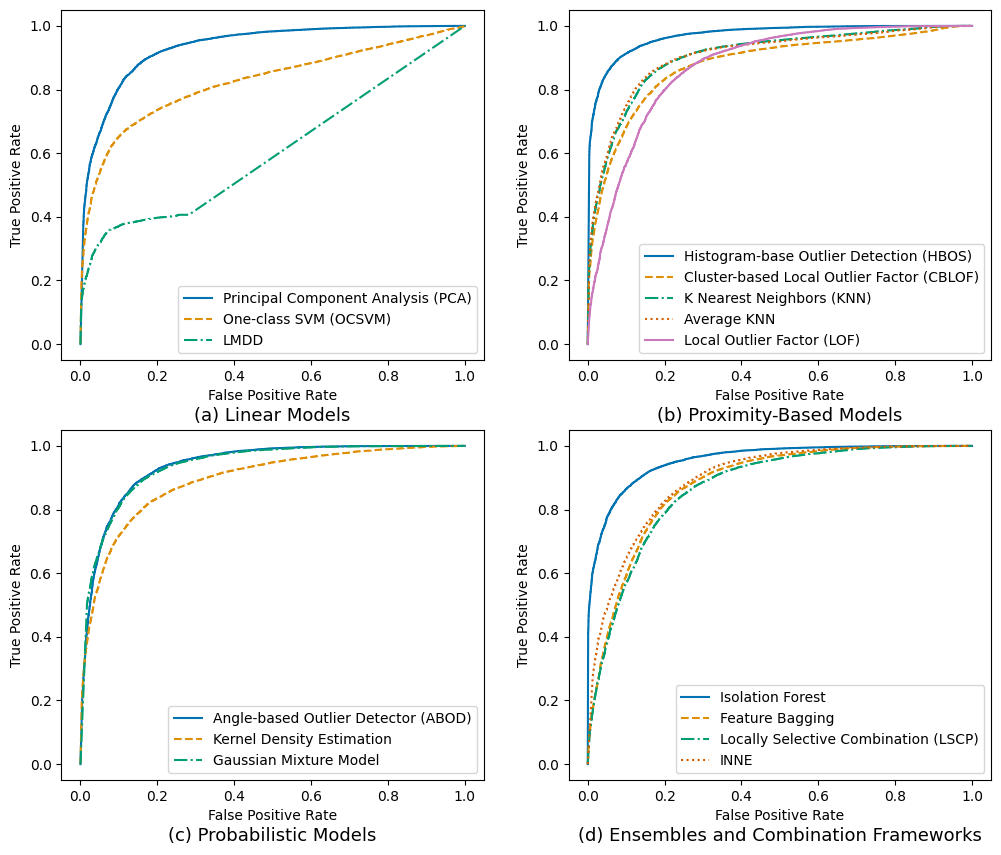

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn's colorblind palette
sns.set_palette("colorblind")

# Define line styles for each classifier
line_styles = ['-', '--', '-.', ':']

# Create a new figure for all groups
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

letters = ['a', 'b', 'c', 'd']
descriptions = ['DD Feature', 'UD Feature', 'H Feature', 'temp']

# Flatten the axes for easy indexing
axes = axes.flatten()

# Loop through each group of classifiers
for idx, (group_name, group) in enumerate(FIGURES.items()):
    ax = axes[idx]

    # Set the x-axis label
    ax.set_xlabel("False Positive Rate")

    # Set the y-axis label
    ax.set_ylabel("True Positive Rate")

    # Loop through each classifier in the group
    for j, (clf_name, res) in enumerate(group.items()):
        # Get the false positive rate and true positive rate from the results
        fpr = res["fpr"]
        tpr = res["tpr"]

        # Plot the ROC curve for the classifier with unique line style
        ax.plot(fpr, tpr, label=clf_name, linestyle=line_styles[j % len(line_styles)])

    # Add legend to the last subplot
    ax.legend()
    ax.text(0.5, -0.16, f"({letters[idx]}) {group_name}", ha='center', va='center', transform=ax.transAxes, fontsize=13)

# Save the plot as an image file
plt.savefig("Figure 3.png", dpi=300)

# Show the plot
plt.show()


In [17]:
best_params_df

,EER,ACC,AUC,Precision,Recall,F1-Score,Parameters
Model,,,,,,,
HBOS,5.97,89.23,97.79,75.77,98.8,85.76,"[n_bins=15, alpha=0.4, tol=0.3, contamination=0.01]"
IForest,7.81,89.37,97.05,92.91,94.4,93.65,"[n_estimators=400, max_samples=0.5, max_features=0.5, bootstrap=True, contamination=0.01, n_jobs=-1, random_state=42]"
LOF,14.71,67.75,92.03,100.00,38.4,55.49,"[n_neighbors=15, leaf_size=10, metric=manhattan, p=1, contamination=0.01]"
OCSVM,15.52,76.30,90.40,93.89,86.0,89.77,"[kernel=rbf, gamma=scale, nu=0.9, coef0=0.0, contamination=0.01]"
PCA,10.43,79.50,94.69,98.84,68.0,80.57,"[n_components=5, whiten=True, svd_solver=auto, contamination=0.01, random_state=42]"


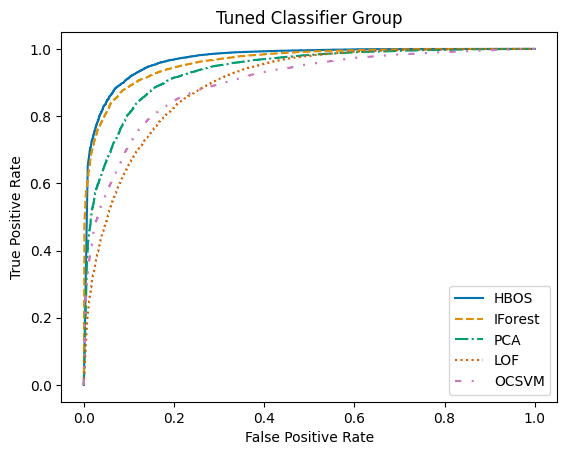

In [94]:
import matplotlib.pyplot as plt

# Model parameters
parameters = {
    "HBOS": {"n_bins": 15, "alpha": 0.4, "tol": 0.3, "contamination": 0.01},
    "IForest": {"n_estimators": 400, "max_samples": 0.5, "max_features": 0.5, "bootstrap": True, "contamination": 0.01, "n_jobs": -1, "random_state": 42},
    "PCA": {"n_components": 5, "whiten": True, "svd_solver": "auto", "contamination": 0.01, "random_state": 42},
    "LOF": {"n_neighbors": 15, "leaf_size": 10, "metric": "manhattan", "p": 1, "contamination": 0.01},
    "OCSVM": {"kernel": "rbf", "gamma": "scale", "nu": 0.9, "coef0": 0.0, "contamination": 0.01}
}

# Visualizing ROC Curves for Tuned Classifier Group
TUNED_RESULTS={}
# Create a new figure for the tuned group
plt.figure("Tuned")

# Set the title of the figure as the group name
plt.title("Tuned Classifier Group")

# Set the x-axis label
plt.xlabel("False Positive Rate")

# Set the y-axis label
plt.ylabel("True Positive Rate")

# Define line styles for different classifiers
line_styles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5, 1, 5)), (0, (1, 10))]

# Loop through each classifier in the group
for i, (clf_name, params) in enumerate(parameters.items()):
    # Construct the model with the current parameter combination
    clf = eval(f"{clf_name}(**params)")  # Use the provided parameters directly
    
    # Evaluate the classifier and get the scores (assuming evaluate_classifier function is defined)
    allUserScores, allImposterScores, res = evaluate_classifier(clf)
    
    # Combine the user and imposter scores
    allScores = np.append(allUserScores, allImposterScores)
    
    # Create labels for the scores
    LABELS = [0] * len(allUserScores) + [1] * len(allImposterScores)
    
    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(LABELS, allScores)
    TUNED_RESULTS[clf_name] = res
    # Visualize the ROC curve for the current classifier
    plt.plot(fpr, tpr, label=f"{clf_name}", linestyle=line_styles[i % len(line_styles)])  # Display parameters as the label

# Add a legend to the plot
plt.legend()

# Save the plot as an image file
plt.savefig("Tuned_Classifiers_ROC.png", dpi=300) 

# Show the plot
plt.show()


In [95]:
tuned_results_df = pd.DataFrame.from_dict(TUNED_RESULTS, orient="index")
tuned_results_df

,EER,ACC,AUC,Precision,Recall,F1-Score
HBOS,5.97,89.23,97.79,75.77,98.8,85.76
IForest,7.81,89.37,97.05,92.91,94.4,93.65
PCA,10.43,79.50,94.69,98.84,68.0,80.57
LOF,14.71,67.75,92.03,100.00,38.4,55.49
OCSVM,15.52,76.30,90.40,93.89,86.0,89.77


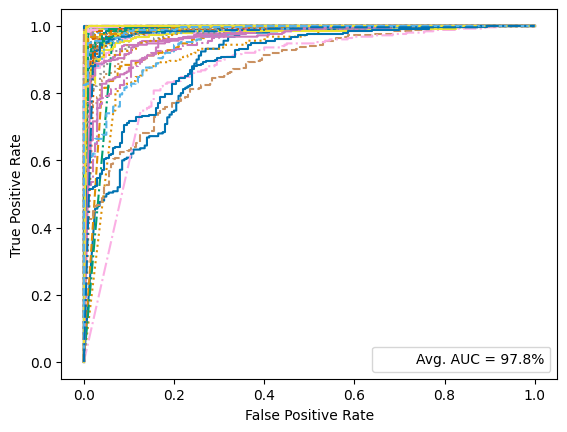

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.patches as mpatches
from pyod.models.hbos import HBOS

# Initialize lists to store the AUC, EER, and accuracy scores
AUCS = []
EERS = []
ACCS = []

# Load data
data = pd.read_csv("DSL-StrongPasswordData.csv")
subjects = data["subject"].unique()

# Define line styles for different subjects
line_styles = ['-', '--', '-.', ':']

# Loop through each subject
for i, subject in enumerate(subjects):

    # Get the genuine user data for the current subject
    genuine_user_data = data.loc[data["subject"] == subject, "H.period":]

    # Get the imposter data for all subjects except the current subject
    imposter_data = data.loc[data["subject"] != subject, :]

    # Split the genuine user data into training and testing sets
    train = genuine_user_data[:200].values
    test_genuine = genuine_user_data[200:].values

    # Get the imposter data for testing
    test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":].values

    # Initialize and fit the HBOS classifier
    clf = HBOS(n_bins=15, alpha=0.4, tol=0.3, contamination=0.01)
    clf.fit(train)

    # Get the anomaly scores for the genuine user data and imposter data
    user_scores = clf.predict_proba(test_genuine)
    imposter_scores = clf.predict_proba(test_imposter)

    # Create the labels for the ROC curve
    labels = [0] * len(user_scores) + [1] * len(imposter_scores)

    # Create the scores for the ROC curve
    temp_scores = np.append(user_scores[:, 1], imposter_scores[:, 1])

    # Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
    fpr, tpr, thresholds = roc_curve(labels, temp_scores, drop_intermediate=False, pos_label=1)

    # Plot the ROC curve with different line styles for each subject
    plt.plot(fpr, tpr, linestyle=line_styles[i % len(line_styles)])

    # Calculate and store the AUC
    AUCS.append(roc_auc_score(labels, temp_scores))

# Set the x-axis label
plt.xlabel("False Positive Rate")

# Set the y-axis label
plt.ylabel("True Positive Rate")

# Get the existing handles and labels for the legend
handles, labels = plt.gca().get_legend_handles_labels()

# Create a patch with no color for the average AUC label
patch = mpatches.Patch(color="none", label="")

# Add the patch and label to the handles and labels lists
handles.append(patch)
labels.append("Avg. AUC = " + str(round(np.mean(AUCS), 3) * 100) + "%")

# Add the legend to the plot
plt.legend(handles, labels, loc="lower right")

# Save the plot as an image file
plt.savefig("HBOS-Tuned.png", dpi=300) 

# Show the plot
plt.show()


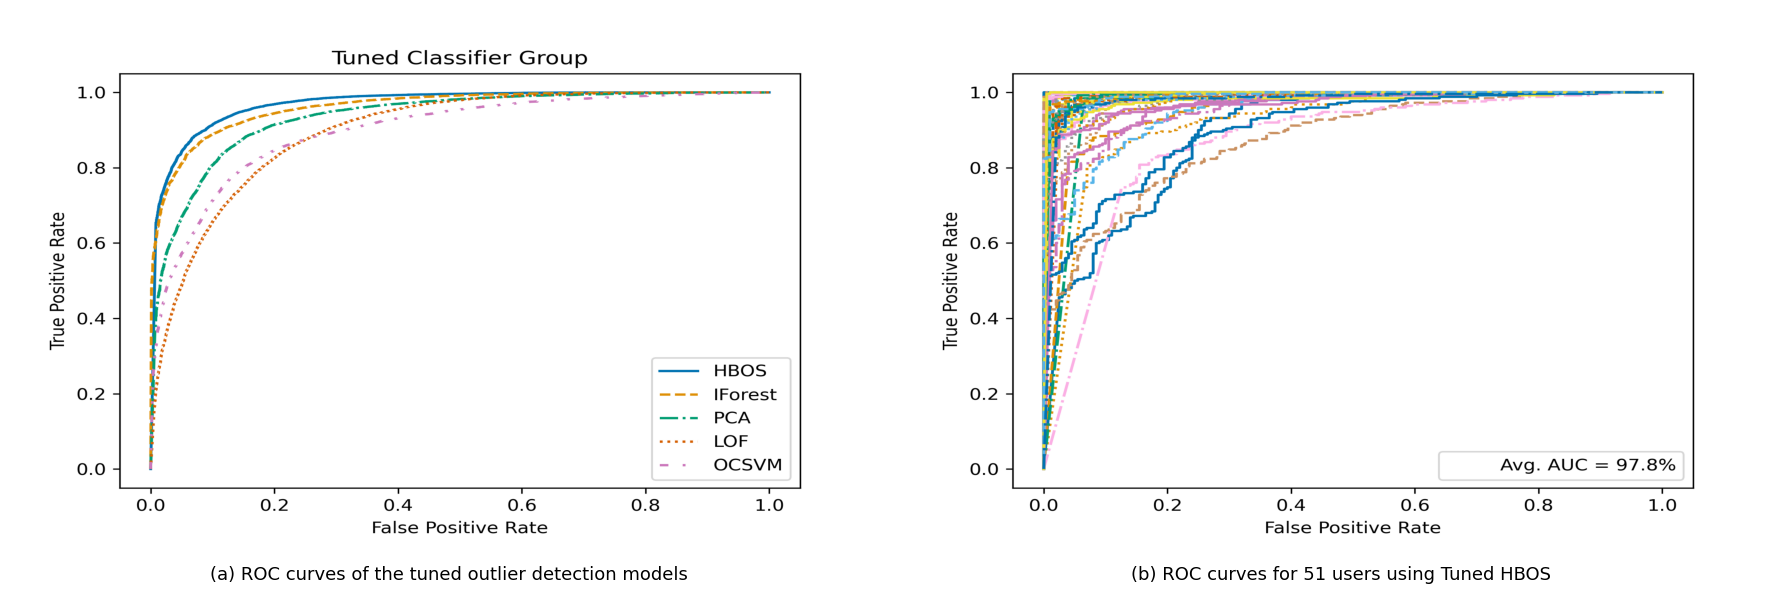

In [99]:
import matplotlib.pyplot as plt

# Load the saved figures
tuned_fig = plt.imread("Tuned_Classifiers_ROC.png")
hbos_fig = plt.imread("HBOS-Tuned.png")

# Create a new figure and plot the images
plt.figure(figsize=(18, 6))

# Plot the tuned classifiers ROC curve
plt.subplot(1, 2, 1)
plt.imshow(tuned_fig, aspect='auto')
plt.axis('off')  # Hide axis
plt.text(0.5, -0.05, "(a) ROC curves of the tuned outlier detection models", ha='center', va='center', transform=plt.gca().transAxes, fontsize=13)

# Plot the HBOS-Tuned ROC curve
plt.subplot(1, 2, 2)
plt.imshow(hbos_fig, aspect='auto')
plt.axis('off')  # Hide axis
plt.text(0.5, -0.05, "(b) ROC curves for 51 users using Tuned HBOS", ha='center', va='center', transform=plt.gca().transAxes, fontsize=13)

# Save the merged figure
plt.savefig("Figure 4.png", bbox_inches='tight', dpi=300)  # Apply bbox_inches='tight' to minimize whitespace

# Show the merged figure
plt.tight_layout()
plt.show()
